In [1]:
import os
import gym
import matplotlib.pyplot as plt
import griddly
import itertools
import numpy as np
import seaborn as sns
import torch
import wandb
import skvideo.io

from skimage.transform import resize
from skimage.color import rgba2rgb
from models.disentangle_network import DisentangleNetwork
from utils import wrap_env

In [2]:
client = wandb.Api()

In [3]:
def make_env(env_name):
    env = wrap_env(env_name, max_frames=500, frame_stack=False, obs_shape=(84,84), test=True, punishment=1, no_ext=True)
    env.seed(100)
    return env

In [21]:
PATH = "ut-rl-control/cen-rl/{}"

def load_config(run_id):
    run = client.run(PATH.format(run_id))
    config = run.config
    return config

def load_model(run_id, env, download=False):
    run_path = PATH.format(run_id)
    config = load_config(run_id)
    
    num_actions = min(10, env.action_space.n)
    image_channels = env.observation_space.shape[0]
    if config['IR_module'] == 'CTRL':
        mask_network = DisentangleNetwork(image_channels, num_actions, config['ctrl_hidden_size'], config['ctrl_channels'], config['ctrl_latent_size'], config['ctrl_encoder_out']).to(device).eval()
        combine_masks = False
        model_name = 'disentanglement'
    else:
        raise ValueError('Model type not supported ({})'.format(config['IR_module']))

    if download:
        wandb.restore('{}_{}_network.pth'.format(model_name, run_id), run_path=run_path, replace=True)
        
    # mask_network.load_state_dict(torch.load('{}_{}_network.pth'.format(model_name, run_id), map_location=device), strict=True)
    mask_network = torch.load('{}_{}_network.pth'.format(model_name, run_id), map_location=device)

    return mask_network, combine_masks

In [22]:
cen_run_id = 'upivs3t0'
config = load_config(cen_run_id)

device = torch.device('cpu')
env = make_env(config['env_name'])

cen_network, cen_combine_masks = load_model(cen_run_id, env)
config['combine_masks'] = cen_combine_masks

[2021-11-26 16:12:42.408] [info] Loading GDY file: /home/ocorcoll/projects/controllable-IR/gdy_envs/butterflies_spiders_easy.yml
[2021-11-26 16:12:42.411] [info] Loading GDY file Version: 0.1.
[2021-11-26 16:12:42.411] [info] Loading 5 objects...
[2021-11-26 16:12:42.411] [info] Loading 5 actions...
[2021-11-26 16:12:42.412] [info] Loading Environment...
[2021-11-26 16:12:42.412] [info] Loaded 13 levels
CNNDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
    (8): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )

In [6]:
def to_video(frames, output_file='eval_video.mp4'):
    fps = '12'
    writer = skvideo.io.FFmpegWriter(output_file, 
        inputdict={'-r': fps},
        outputdict={'-r': fps},
    )

    for frame in frames:
        writer.writeFrame(frame)
    writer.close()

def mask_observation(observation, mask, threshold=0.03, use_negative=True):
    if use_negative:
        mask = np.abs(mask)

    binary_mask = (mask >= threshold).astype(float) + 0.7
    binary_mask = resize(binary_mask, observation.shape)
    
    image = observation * binary_mask
    # image = np.concatenate([observation / 255., binary_mask], axis=-1)
    # image = rgba2rgb(image)
    # image = np.clip(image * 255, 0, 255).astype(np.uint8)
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

In [23]:
def process_obs(obs):
    if obs is None:
        observation_raw = env.reset()
    else:
        observation_raw = obs

    if config['env_name'].startswith('GDY'):
        observation = torch.from_numpy(observation_raw).to(device) / 255.
        observation_raw = np.transpose(observation_raw, (1, 2, 0))
    else:
        observation = torch.from_numpy(np.asarray(observation_raw)).to(device) / 255.
        observation_raw = env.raw_last_obs

    return observation, observation_raw

num_actions = min(10, env.action_space.n)
output_channels = env.observation_space.shape[0]
observation, observation_raw = process_obs(None)

episode = list()
episode_index = 0
time_to_death = 0
data = list()
while len(data) < 10:
    action = torch.randint(num_actions, (1,)).to(device)

    next_observation, _, done, info = env.step(action.item())
    next_observation, next_observation_raw = process_obs(next_observation)
    total_effect = next_observation[-output_channels:] - observation[-output_channels:]

    with torch.no_grad():
        cen_controlled_mask, cen_normal_mask, _, _ = cen_network.forward(observation.unsqueeze(0), action)

    cen_controlled_mask_raw = cen_controlled_mask
    cen_normal_mask_raw = cen_normal_mask

    episode.append(mask_observation(next_observation_raw, cen_controlled_mask_raw.permute(0, 2, 3, 1).squeeze().cpu().numpy()))

    if 'ale.lives' in info:
        done = ('needs_reset' in info and info['needs_reset']) or info['ale.lives'] == 0
        
    if done:
        if len(episode) > 30:
            to_video(episode, "videos/video_{}_{}.avi".format(config['env_name'], episode_index))
            
        next_observation, next_observation_raw = process_obs(None)
        episode = list()
        episode_index += 1
        time_to_death = 0

    if not done:
        if len([event for event in info[0]['History'] if event['SourceObjectName'] == 'catcher' and event['DestinationObjectName'] == 'butterfly']) > 0:
            data.append((observation_raw, next_observation_raw, cen_controlled_mask_raw, cen_normal_mask_raw, total_effect, cen_controlled_mask))
        
    observation = next_observation
    observation_raw = next_observation_raw
    
to_video(episode, "videos/video_{}_{}.avi".format(config['env_name'], episode_index))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


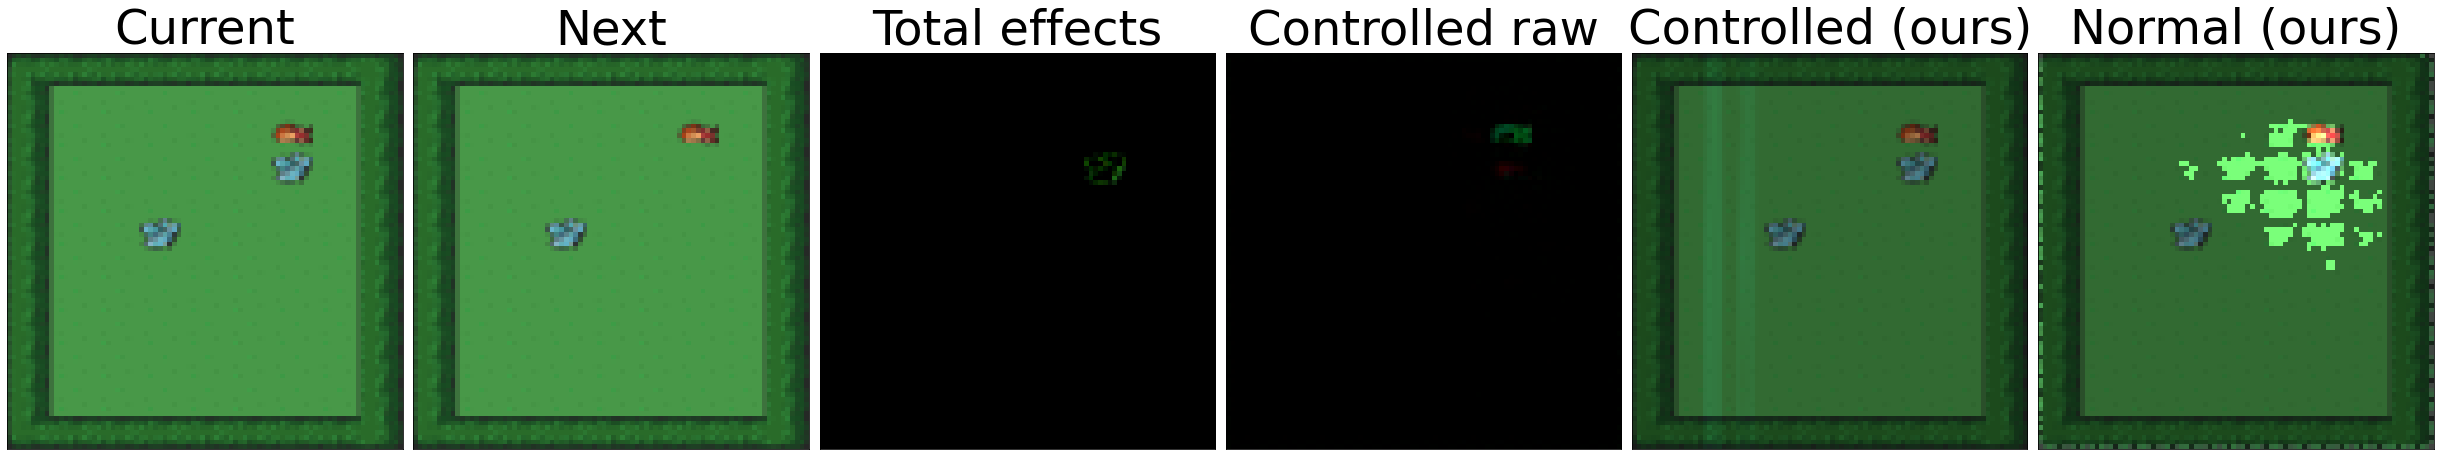

In [30]:
fig, axes = plt.subplots(figsize=(34, 24), ncols=6, nrows=1)

index = np.random.randint(len(data))
print(index)
item = data[index]
observation = item[0]
next_observation = item[1]
cen_controlled_mask = item[2].squeeze().permute(1, 2, 0).cpu().numpy()
cen_normal_mask = item[3].squeeze().cpu().numpy().squeeze()
total_effect = item[4].permute(1, 2, 0).cpu().numpy().squeeze()
threshold_cen_controlled_mask = item[5].cpu().numpy().squeeze()

for ax in axes.flat:
    ax.tick_params(axis="both", which = "both", bottom = False, top = False, left=False,right=False, labelleft=False,labelbottom=False)
    ax.imshow(np.zeros_like(observation))

axes[0].imshow(observation)
axes[1].imshow(next_observation)
axes[2].imshow(total_effect, vmin=-1, vmax=1)
axes[3].imshow(cen_controlled_mask, vmin=-1, vmax=1)
axes[4].imshow(mask_observation(observation, threshold_cen_controlled_mask))
axes[5].imshow(mask_observation(observation, (np.abs(cen_normal_mask) > 0.01).max(axis=0)[None].transpose(1, 2, 0)))


axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
axes[2].xaxis.set_label_position('top')
axes[3].xaxis.set_label_position('top')
axes[4].xaxis.set_label_position('top')
axes[5].xaxis.set_label_position('top')

axes[0].set_xlabel('Current', color='black', fontsize=48., labelpad=10.)
axes[1].set_xlabel('Next', color='black', fontsize=48., labelpad=10.)
axes[2].set_xlabel('Total effects', color='black', fontsize=48., labelpad=10.)
axes[3].set_xlabel('Controlled raw', color='black', fontsize=48., labelpad=10.)
axes[4].set_xlabel('Controlled (ours)', color='black', fontsize=48., labelpad=10.)
axes[5].set_xlabel('Normal (ours)', color='black', fontsize=48., labelpad=10.)

plt.tight_layout()
plt.show()